# PCA-BO on the Shapes Dataset

This notebook plans to implement (not currently implemented cf. TODO below) PCA with weighted retraining via supervised PCA by analogy to VAE Bayesian optimization with weighted retraining (Tripp et al., Sample-Efficient Optimization in the Latent Space of Deep Generative Models via Weighted Retraining, NeurIPS 2020).

In [175]:
"""
Define plotting preferences.
"""

import matplotlib

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1'

## 1. Construct the Shapes Dataset to Test the Implementation

In [176]:
"""
Construct the Shapes optimization benchmark dataset from Tripp et al.,
Sample-Efficient Optimization in the Latent Space of Deep Generative Models 
via Weighted Retraining, NeurIPS 2020. 
Adapted from: https://github.com/cambridge-mlg/weighted-retraining
"""

from tqdm.auto import trange

from matplotlib import pyplot as plt
import numpy as np

# Hyperparameters from 
# https://arxiv.org/abs/2006.09191

grid_size = 16 # image dimension
min_size = 4
max_size = 8
shuffle_seed = None # Int specifying the shuffle seed
min_col = None # min column to start spanning, shifts rectangles to the left
max_col = None # max column to start spanning
num_replicates = 1 # number of times to replicate each point

# Make all the rectangles
print("Making Dataset")
img_list = []
for rect_height in trange(min_size, max_size + 1):
    for rect_width in [rect_height]:  # Because it is squares only
        for row in range(grid_size - rect_height + 1):

            # Specify which columns to span
            if min_col is None:
                min_col = 0
            if max_col is None:
                max_col = grid_size
            for col in range(min_col, min(grid_size - rect_width + 1, max_col)):
                arr = np.zeros((grid_size, grid_size))
                arr[row : row + rect_height, col : col + rect_width] = np.ones(
                    (rect_height, rect_width)
                )
                # Append the same image multiple times
                for _ in range(num_replicates):
                    img_list.append(arr)

img_array = np.array(img_list)
print(f"Dataset created. Total of {len(img_array)} points")
print(f"Array size {img_array.nbytes / 1e9:.1f} GB")

# Possibly shuffle
if shuffle_seed is not None:
    print("Shuffling!")
    np.random.seed(shuffle_seed)
    np.random.shuffle(img_array)

# Calculate areas
areas = np.sum(img_array, axis=(1, 2)).astype(float)

Making Dataset


  0%|          | 0/5 [00:00<?, ?it/s]

Dataset created. Total of 615 points
Array size 0.0 GB


Text(0.5, 0.98, 'Example Shapes Images')

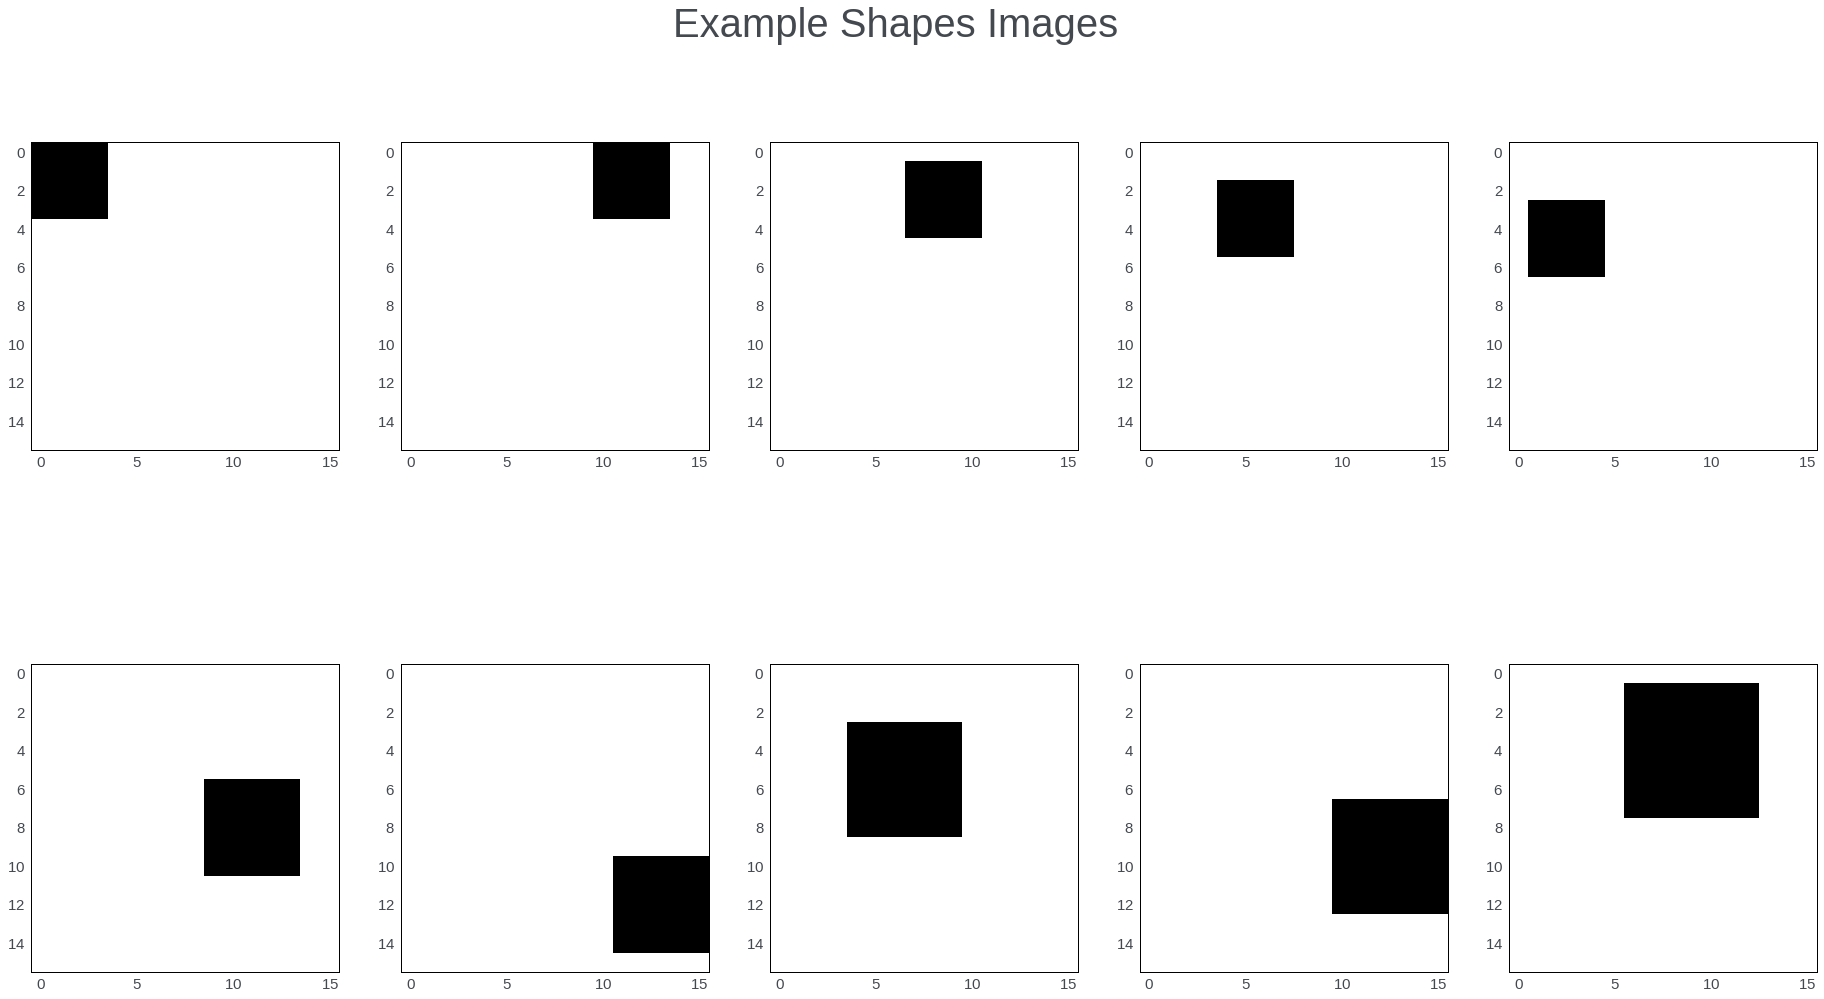

In [177]:
"""
Plot example images from the dataset.
"""

fig, ax = plt.subplots(2, 5, figsize = (32, 16))
ax = ax.reshape(-1)

for i in range(10):
    if i < 5:
        f = ax[i].imshow(img_array[10*i], cmap=plt.cm.gray_r)
    else:
        f = ax[i].imshow(img_array[50*i], cmap=plt.cm.gray_r)

plt.suptitle('Example Shapes Images', fontsize=40)

In [180]:
"""
Define the relative L2-error for the reconstruction of the image data from the low-dimensional PCA embedding.
"""

def rel_l2_error(recons, ground_truth):
    """"Relative L2-error.

    Args: 
        recons: `[b x d]` NumPy array of flattened reconstructions.
        ground_truth: `[b x d]` NumPy array of flattened ground truth images.

    Returns:
        Float specifying the average l2 error across the dataset.
    """

    return np.mean(np.linalg.norm((recons - ground_truth), axis=-1) / np.linalg.norm(ground_truth, axis=-1))

## 2. Test Reconstruction Performance of PCA on the Shapes Dataset

Data is split in an 80/20 train/test ratio and the ability of PCA to reconstruct the test images is assessed via the
relative L2 error defined above.

In [181]:
"""
Divide the Shapes dataset into train/test.
"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['shapes_images'], data['areas'], test_size=0.2, random_state=42)

n_train_data = len(X_train)
n_test_data = len(X_test)
img_dim = len(X_train[0]) # 16 x 16

# Flatten images
X_train = X_train.reshape(n_train_data, img_dim**2)
X_test = X_test.reshape(n_test_data, img_dim**2)

In [182]:
"""
Fit PCA and measure reconstruction error (relative l2 error) on the test set.
"""

import time

from sklearn.decomposition import PCA

start_time = time.time()

# Runtime of PCA is ca. 10 seconds
pca_x = PCA(n_components=16)
pca_x.fit(X_train)
recons_x = pca_x.inverse_transform(pca_x.transform(X_test))
test_error = rel_l2_error(recons_x, X_test)

end_time = time.time()
print(f'Runtime is {(end_time - start_time):.2f} seconds')

def round_binary(reconstructions):
    """round reconstructions to binary pixel values.

    Args:
        reconstructions: NumPy array of reconstructions.

    Returns:
        rounded binary-valued array
    """

    reconstructions = reconstructions > 0.5
    reconstructions = reconstructions.astype(float)
    return reconstructions

recons_x = round_binary(recons_x)

Runtime is 0.02 seconds


Text(0.5, 0.98, 'Example Shapes Reconstructions')

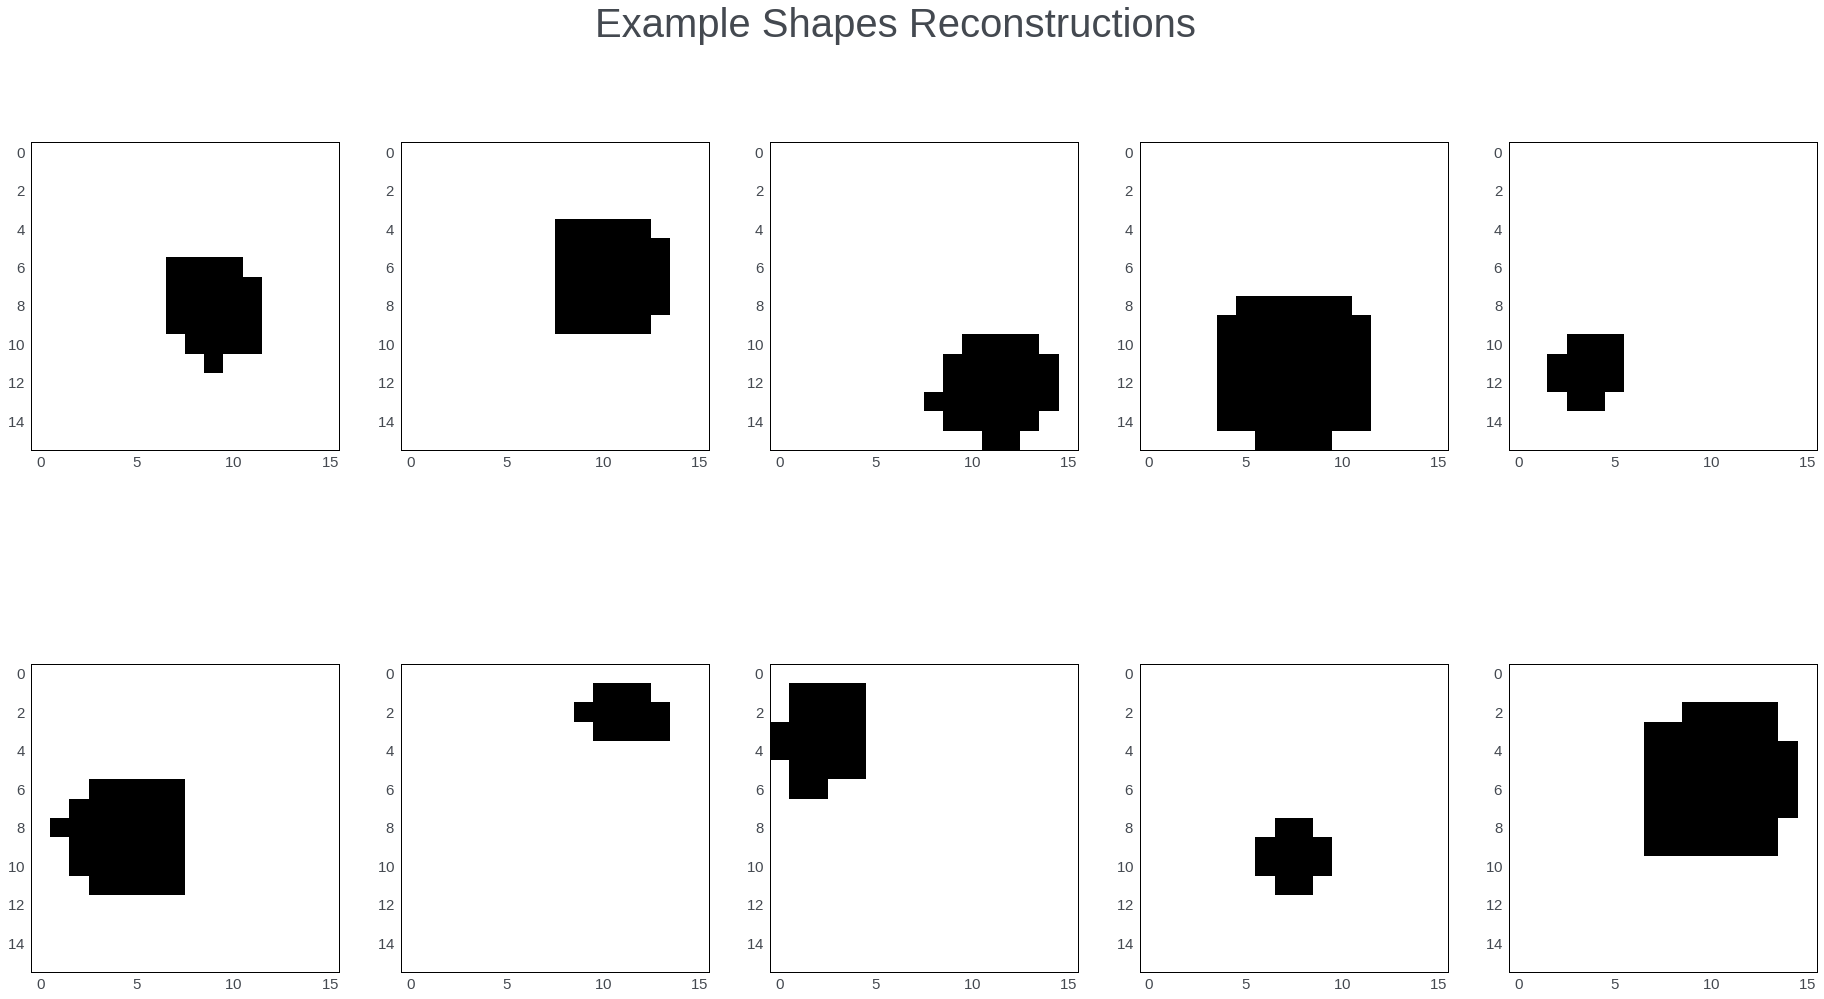

In [183]:
"""
Plot example reconstructions from the PCA fit.
"""

fig, ax = plt.subplots(2, 5, figsize = (32, 16))
ax = ax.reshape(-1)

for i in range(10):
    if i < 5:
        f = ax[i].imshow(recons_x[1*i].reshape(16, 16), cmap=plt.cm.gray_r)
    else:
        f = ax[i].imshow(recons_x[5*i].reshape(16, 16), cmap=plt.cm.gray_r)

plt.suptitle('Example Shapes Reconstructions', fontsize=40)

# Artefact in predicting negative pixel intensities
# print(np.round(recons_x[5], 2))

In [184]:
print(f'Relative L2 reconstruction error is {100*test_error:.2f}%')

Relative L2 reconstruction error is 48.76%


In [185]:
"""
GP regression experiment mapping from PCA embedding to area to assess generalization performance.
"""

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior, NormalPrior
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

def initialize_model(train_z, train_y):
    """Utility function for defining the surrogate model for the objective.

    Args:
        train_z: Tensor of latent embeddings z.
        train_y: Tensor of labels (image areas) z.

    Returns:
        mll, gp_model
    """

    mean_module = ConstantMean(constant_prior=NormalPrior(loc=0.0, scale=1.0))
    base_kernel = MaternKernel(nu=2.5)
    scale_prior = GammaPrior(torch.tensor(2.0, **tkwargs), torch.tensor(0.15, **tkwargs))
    covar_module = ScaleKernel(base_kernel=base_kernel, outputscale_prior=scale_prior)
    noise_prior = GammaPrior(torch.tensor(0.9, **tkwargs), torch.tensor(1.0, **tkwargs))

    likelihood = GaussianLikelihood(noise_prior=noise_prior, noise_constraint=GreaterThan(1e-6)) 
    gp_model = SingleTaskGP(train_z, train_y, likelihood=likelihood, covar_module=covar_module, mean_module=mean_module, 
                            outcome_transform=Standardize(train_y.shape[-1]))
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    return mll, gp_model

# Typecast data to tensors
train_z = torch.tensor(pca_x.transform(X_train), dtype=torch.float64)
train_y = torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1)
test_z = torch.tensor(pca_x.transform(X_test), dtype=torch.float64)

# Initialize the likelihood and model with an outcome transform
# to standardize the outputs
mll, gp_model = initialize_model(train_z, train_y)

# Use the BoTorch utility for fitting GPs using the L-BFGS-B optimiser

time_fit = False

if time_fit:

    import time
    start_time = time.time()
    fit_gpytorch_model(mll)
    end_time = time.time()
    print(f' training time is {end_time - start_time}')

else:

    fit_gpytorch_model(mll)

observed_pred = gp_model(test_z).mean.detach()
observed_pred, _ = gp_model.outcome_transform.untransform(observed_pred)

# outcome_transform.untransform prepends a dimension
observed_pred = observed_pred.squeeze()

mse = mean_squared_error(observed_pred.numpy(), y_test)
mae = mean_absolute_error(observed_pred.numpy(), y_test)

# print(observed_pred.numpy())
# print(y_test)

print(f'MSE on test set is :{mse:.2f} pixels squared')
print(f'MAE on test set is :{mae:.2f} pixels')

MSE on test set is :0.08 pixels squared
MAE on test set is :0.22 pixels
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [186]:
"""
Define objective function and data generation process for the
Shapes dataset.
"""

def area(img):
    r"""Define the objective function, the area of the shape

    Args:
        img: `dxd` Tensor representing a binary image for the Shapes dataset where d is the image dimension

    Returns:
        area: a float specfiying the area of the shape
    """    

    return torch.sum(img).unsqueeze(-1) # add output dimension


def generate_initial_data(x_train_bo, z_train_bo, y_train_bo):
    r"""Generate training data.

    Args:
        x_train_bo: NumPy array of training images
        z_train_bo: Tensor of latent training image encodings
        y_train_bo: Tensor of training image areas (objective function values)

    Return:
        (z, x, y) triples + best representing the initialization set together with the best
        observed y so far where z is the latent embedding, x is the image and y is the area.
    """
    # typecast NumPy array of images to torch tensor

    train_size = 492 # size of train set
    n = 50 # subset size to give to GP
    idx_tensor = torch.randperm(train_size) 

    x_train_bo = torch.tensor(x_train_bo, dtype=torch.float64)[idx_tensor][0:n]
    z_train_bo = z_train_bo[idx_tensor][0:n]
    y_train_bo = y_train_bo[idx_tensor][0:n]
    best_observed_value = y_train_bo.max().item()

    return z_train_bo, x_train_bo, y_train_bo, best_observed_value

# Original images are defined as "X_train" above.
z_train_bo, _, y_train_bo, best_observed_value = generate_initial_data(X_train, train_z, train_y)

print(best_observed_value)

64.0


In [195]:
from botorch.optim import optimize_acqf

# Were 20 and 512
num_restarts = 2
raw_samples = 32
latent_dim = 16 # image dimension
# Bounds from the weighted retraining paper (change to bounds of PCA representation - probably plays a big role on BO performance)
bounds = torch.tensor([[-1000.0] * latent_dim, [1000.0] * latent_dim])

def optimize_acqf_and_get_observation(acq_func, pca_model):
    """Optimizes the acquisition function, and returns a new candidate 
       and a noiseless observation.

    Args:
        acq_func: Choice of acquisition function
        pca_model: PCA model instance

    Returns:
        new_z: sampled z
        new_x: corresponding x
        obj: objective evaluated at the corresponding x for the sampled z.
    """

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,  # used for initialization heuristic
        options={"batch_limit": 1, "maxiter": 200},
    )

    # observe new values 
    new_z = candidates.detach()
    # pca transform requires NumPy array
    new_z_numpy = new_z.numpy()
    new_x = torch.tensor(round_binary(pca_model.inverse_transform(new_z_numpy)))
    obj = area(new_x).unsqueeze(-1)  # add output dimension
    obj = obj.detach()
    return new_z, new_x, obj


def update_random_observations(best_random, pca_model, latent_dim):
    """Simulates a quasi-random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.

    Args:
        best_random: List representing the best random objective values observed
            per iteration so far.
        pca_model: PCA model instance whose embedding space is used to generate random 
            samples.
        latent_dim: int specifying the embedding dimension

    Returns:
        best_random: List for best random objective values observed so far
            per iteration.
    """
    sample = np.random.uniform(-1000, 1000, (1, latent_dim)) # sample from embedding space
    rand_x = torch.tensor(round_binary(pca_model.inverse_transform(sample)))
    next_random_best = area(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))       
    return best_random

In [196]:
"""
BO loop using a static, pre-trained VAE
"""

from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings


warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


N_TRIALS = 3
N_BATCH = 50

verbose = False

best_observed_all_ei, best_random_all = [], []

torch.manual_seed(0)

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_random = [], []

    best_value_ei = 0
    best_value_random = 0
    
    # call helper functions to generate initial training data and initialize model
    train_z_ei, train_x_ei, train_obj_ei, best_observed_value_ei = generate_initial_data(X_train, train_z, train_y)
    mll_ei, model_ei = initialize_model(train_z_ei, train_obj_ei)
    
    best_observed_ei.append(best_observed_value_ei)
    best_random.append(best_value_random)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.monotonic()
        
        # fit the models
        fit_gpytorch_mll(mll_ei)

        ei = qExpectedImprovement(
            best_f=np.max(best_observed_ei),
            model=model_ei, 
            X_baseline=train_z_ei,
        )
        
        # optimize and get new observation
        new_z_ei, new_x_ei, new_obj_ei = optimize_acqf_and_get_observation(ei, pca_x)

        #print(f'Area of generated shape is {new_obj_ei}')
                
        # update training points
        train_z_ei = torch.cat([train_z_ei, new_z_ei])
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])

        # update progress
        best_random = update_random_observations(best_random, pca_x, latent_dim)
        if new_obj_ei > best_value_ei:
            best_value_ei = new_obj_ei
        best_observed_ei.append(best_value_ei)

        mll_ei, model_ei = initialize_model(train_z_ei, train_obj_ei)
        
        t1 = time.monotonic()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, ei) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_ei.append(best_observed_ei)
    best_random_all.append(best_random)


Trial  1 of 3 ..................................................
Trial  2 of 3 ..................................................
Trial  3 of 3 ..................................................

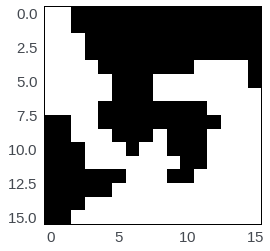

In [197]:
plt.imshow(new_x_ei.reshape(16, 16), cmap=plt.cm.gray_r)

(49,)
(3, 49)
[[133. 133. 133. 133. 133. 133. 133. 143. 143. 174. 178. 178. 178. 178.
  178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178.
  178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178.
  178. 178. 178. 178. 178. 178. 178.]
 [134. 134. 149. 149. 149. 149. 170. 170. 170. 170. 170. 170. 170. 170.
  170. 170. 170. 170. 170. 170. 170. 170. 170. 170. 170. 190. 190. 190.
  190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.
  190. 190. 190. 190. 190. 190. 190.]
 [131. 157. 157. 157. 157. 157. 157. 157. 157. 157. 157. 157. 157. 166.
  166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
  166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 169. 169.
  169. 169. 169. 169. 169. 180. 180.]]
[[183. 183. 183. 183. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186.
  186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186.
  186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186. 186.
  186. 

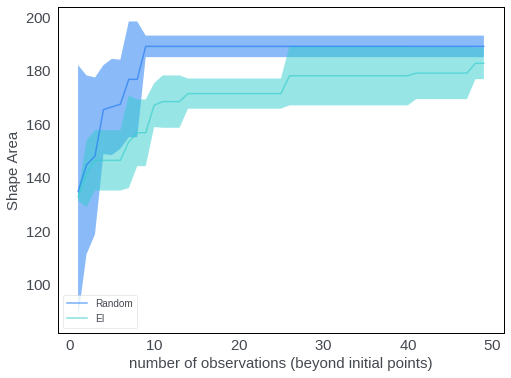

In [198]:
import numpy as np
from matplotlib import pyplot as plt

#%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

best_val_in_train = torch.max(train_y)
iters = np.arange(N_BATCH)[1:]
y_ei = np.asarray(best_observed_all_ei)[:, 2:]
y_rnd =  np.asarray(best_random_all)[:, 2:]

print(iters.shape)
print(y_ei.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# ERRORBAR PLOTS
# ax.errorbar(
#     iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="Random", linewidth=1.5, capsize=3, alpha=0.6
# )
# ax.errorbar(
#     iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="EI", linewidth=1.5, capsize=3, alpha=0.6,
# )

# FILL PLOT
ax.plot(iters, y_rnd.mean(axis=0), label="Random", linewidth=1.5, alpha=0.6)
ax.plot(iters, y_ei.mean(axis=0), label="EI", linewidth=1.5, alpha=0.6)
ax.fill_between(iters, y_rnd.mean(axis=0) - ci(y_rnd), y_rnd.mean(axis=0) + ci(y_rnd), alpha=0.5)
ax.fill_between(iters, y_ei.mean(axis=0) - ci(y_ei), y_ei.mean(axis=0) + ci(y_ei), alpha=0.5)

ax.set(xlabel='number of observations (beyond initial points)', ylabel='Shape Area')
ax.legend(loc="lower left")
print(y_ei)
print(y_rnd)
print(best_val_in_train)
